In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from maxent import MaxEnt
import densities as d
from scipy.stats import kstest

In [2]:
cwd = os.getcwd()
data = np.load(cwd+"/skew_kurt/example_fields.npy")
print(data[0].shape)

(256, 256)


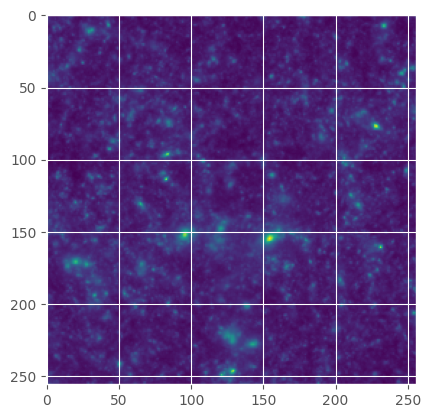

In [3]:
plt.imshow(data[0])
plt.show()

Max: 14.09 || Min: -1.60
Avg: 2.4e-08 || Var: 1.0000
Skewness: 3.04 || Kurtosis: 21.56


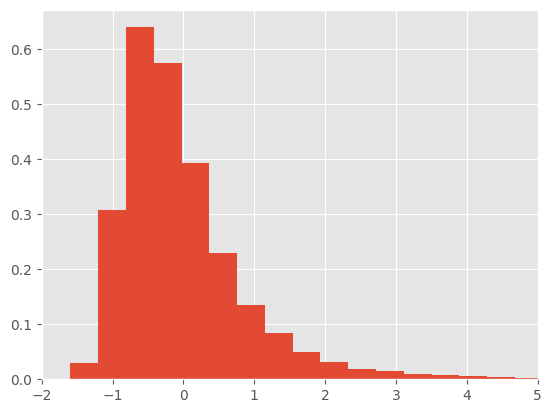

In [4]:
arr = data[0].flatten()
print(f"Max: {np.max(arr):.2f} || Min: {np.min(arr):.2f}")
print(f"Avg: {np.mean(arr):.1e} || Var: {np.var(arr):.4f}")
skew = np.mean(arr**3)
kurt = np.mean(arr**4)
print(f"Skewness: {skew:.2f} || Kurtosis: {kurt:.2f}")
plt.hist(arr, density=True, bins=40)
plt.xlim(-2,5)
plt.show()

Estimate of absolute integration error of norm. const.: 2.792e-08
The resulting parameters:
  Lambda_1 = -0.510
  Lambda_2 = -0.837
  Lambda_3 = 0.203
  Lambda_4 = -0.013


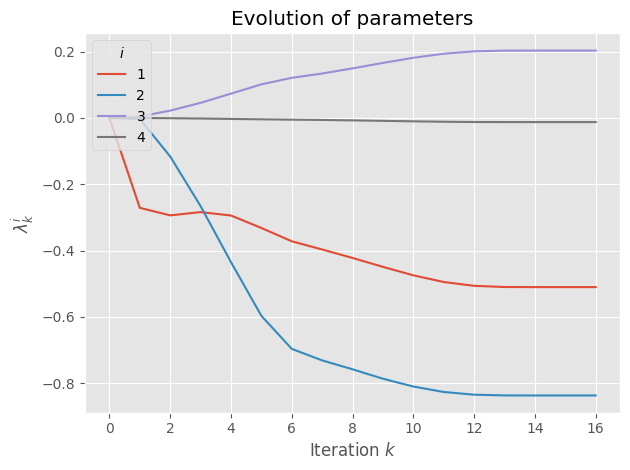

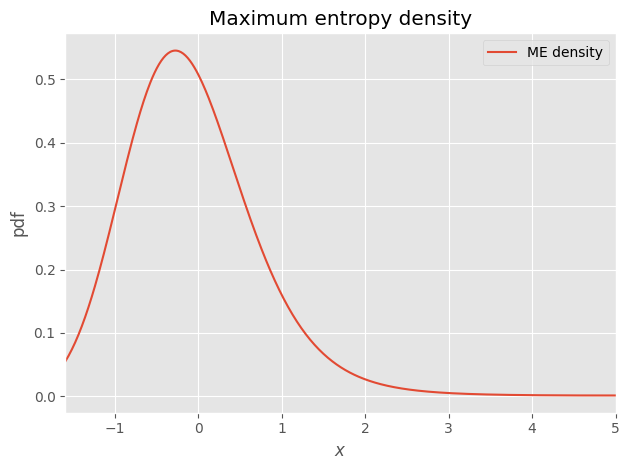

In [5]:
picture = data[0]
picture_flat = picture.flatten()
l = np.min(picture)
u = np.max(picture)+.1
skew = np.mean(arr**3)
kurt = np.mean(arr**4)
n = 150

ob_skewkurt = MaxEnt(support=(l,u),
                     n_quadrature=n,
                     b_constraints=d.b_constraint_skewkurt(skew,kurt),
                     f_vector=d.f_constraint_skewkurt)
ob_skewkurt._algorithm(k_max=200)
ob_skewkurt._visualize_algorithm()
ob_skewkurt._visualize_solution(xlim=(l,5))

0.9927485423018491


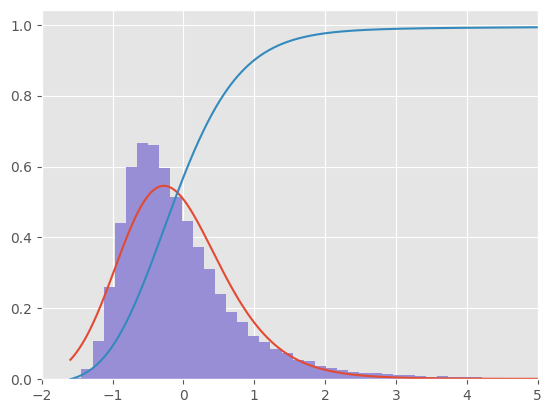

In [6]:
N=500
xx = np.linspace(l,5,N)

y = ob_skewkurt._p(xx)
yy = ob_skewkurt._cdf(xx)
print(yy[-1])
plt.plot(xx,y)
plt.plot(xx,yy)
plt.hist(arr, density=True, bins=100)
plt.xlim(-2,5)
plt.show()


In [7]:
    # a =([ob_skewkurt._cdf(x) for x in picture_flat])

res = kstest(picture_flat, ob_skewkurt._cdf)
print(res)

KstestResult(statistic=np.float64(0.05493682806509326), pvalue=np.float64(2.3495289706807634e-172), statistic_location=np.float32(-0.102563165), statistic_sign=np.int8(1))


In [8]:
# print(min(a),max(a))

In [9]:
def one_rejection_sample(density, xlim, C):
    while(True):
        Y = np.random.uniform(*xlim)
        U = np.random.uniform()
        if(U <= (xlim[1]-xlim[0])*density(Y)/C):
            return Y

def rejection_sampling(size, density, xlim):
    """Univariate rvs, on closed support [a,b]
    - density should be vectorizable"""
    #determine C
    xx = np.linspace(*xlim,N)
    yy = density(xx)
    C = np.max(yy)*(xlim[1]-xlim[0])

    results = np.zeros(size)
    for i in range(size):
        results[i] = one_rejection_sample(density, xlim, C)
    return results



In [11]:
def standardize_image(image):
    mean = np.mean(image)
    var = np.var(image)
    return (image-mean)/np.sqrt(var)

def generate_copy_image(image_raw, extra_upper_l=0.01, n=150, u_show=None):
    
    image = standardize_image(image_raw)
    image_flat = image.flatten()

    l = np.min(image)
    u = np.max(image) + extra_upper_l

    if(u_show == None):
        u_show = u

    skew = np.mean(image_flat**3)
    kurt = np.mean(image_flat**4)

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt(skew,kurt),
                        f_vector=d.f_constraint_skewkurt)
    ob_skewkurt._algorithm(k_max=200, message_norm=False)
    # ob_skewkurt._visualize_algorithm()
    ob_skewkurt._visualize_solution(xlim=(l,5))


    #sample from ME distribution
    n_sample = picture_flat.size
    sample_ME = rejection_sampling(size=n_sample, 
                                   density=ob_skewkurt._p, 
                                   xlim=(l,u))

    fig, ax = plt.subplots(2,1)
    ax[0].imshow(image_raw)

    ax[0].set_title("Raw image")
    ax[0].grid()
    
    #TODO: breaks
    n_breaks = 50
    bins = np.linspace(l, u_show, n_breaks)
    ax[1].hist(image_flat, density=True, bins=bins, alpha=0.6, label="Real")
    ax[1].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    ax[1].set_title("Histogram of pixel values")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Density")
    ax[1].set_xlim(l, u_show)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    res = kstest(picture_flat, ob_skewkurt._cdf)
    print(f"p-value of KS-test on _cdf and real sample: {res.pvalue:.3e}")

def generate_copy_image_6(image_raw, extra_upper_l=0.01, n=150, u_show=None):
    
    image = standardize_image(image_raw)
    image_flat = image.flatten()

    l = np.min(image)
    u = np.max(image) + extra_upper_l

    if(u_show == None):
        u_show = u

    skew = np.mean(image_flat**3)
    kurt = np.mean(image_flat**4)
    moment_6 = np.mean(image_flat**6)

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt_6(skew,
                                                                kurt,
                                                                moment_6),
                        f_vector=d.f_constraint_skewkurt_6)
    ob_skewkurt._algorithm(k_max=200, message_norm=False)
    # ob_skewkurt._visualize_algorithm()
    ob_skewkurt._visualize_solution(xlim=(l,5))


    #sample from ME distribution
    n_sample = picture_flat.size
    sample_ME = rejection_sampling(size=n_sample, 
                                   density=ob_skewkurt._p, 
                                   xlim=(l,u))

    fig, ax = plt.subplots(2,1)
    ax[0].imshow(image_raw)

    ax[0].set_title("Raw image")
    ax[0].grid()
    
    #TODO: breaks
    n_breaks = 50
    bins = np.linspace(l, u_show, n_breaks)
    ax[1].hist(image_flat, density=True, bins=bins, alpha=0.6, label="Real")
    ax[1].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    ax[1].set_title("Histogram of pixel values")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Density")
    ax[1].set_xlim(l, u_show)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    res = kstest(picture_flat, ob_skewkurt._cdf)
    print(f"p-value of KS-test on _cdf and real sample: {res.pvalue:.3e}")

In [22]:
# p = np.vectorize(ob_skewkurt._p)
# sample = rejection_sampling(picture_flat.size,
#                             density=p,
#                             xlim=(l,u))
# print(sample)

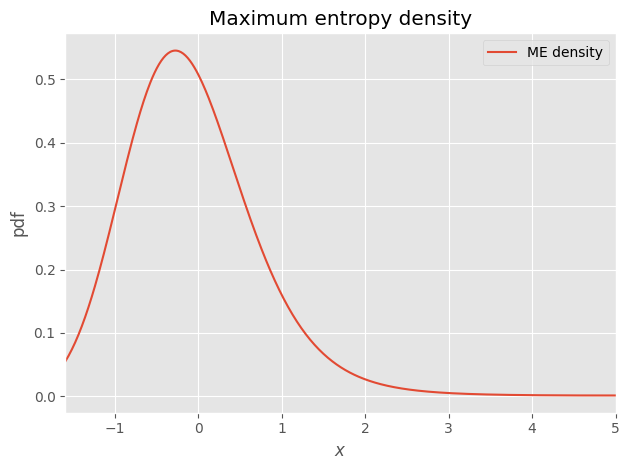

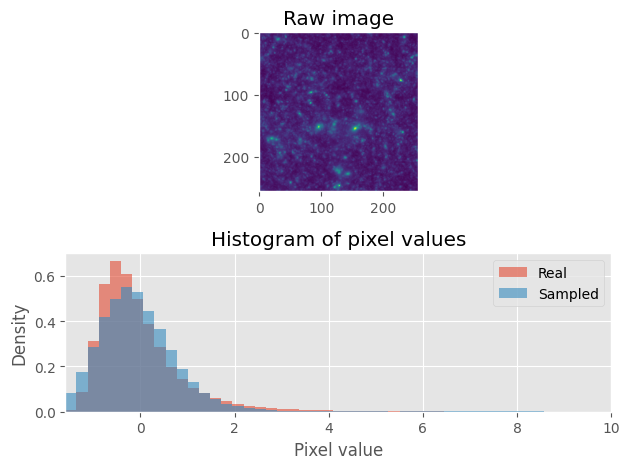

p-value of KS-test on _cdf and real sample: 2.350e-172


In [13]:
generate_copy_image(data[0], 
                    extra_upper_l=0.1, 
                    n=150,
                    u_show=10)

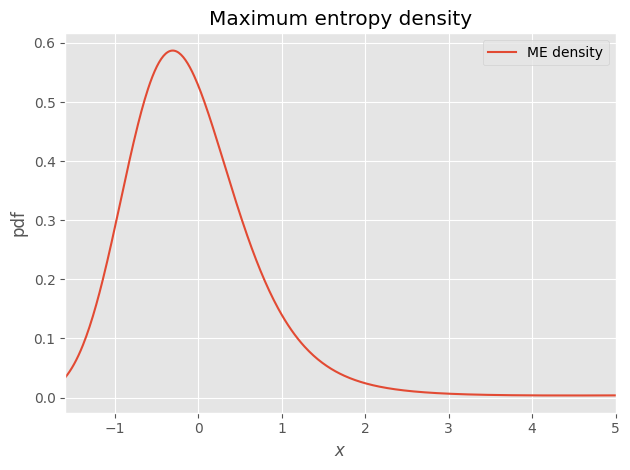

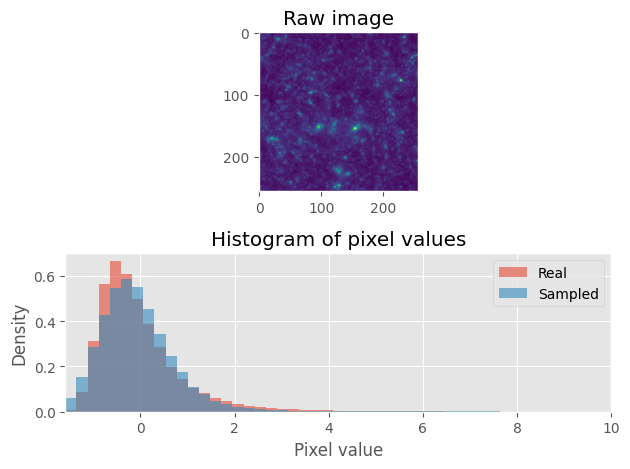

p-value of KS-test on _cdf and real sample: 1.121e-110


In [12]:
generate_copy_image_6(data[0], 
                    extra_upper_l=0.1, 
                    n=150,
                    u_show=10)